In [1]:
from dataset import HW3Dataset
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

data = HW3Dataset(root='data/hw3/')

<IPython.core.display.Javascript object>

In [10]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import torch
from torch.nn import Linear
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features + 1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv3(x, edge_index)
        return x


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features + 1, hidden_channels, heads=7)
        self.conv2 = GATConv(hidden_channels * 7, hidden_channels, heads=6)
        self.conv3 = GATConv(hidden_channels * 6, data.num_classes, heads=6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv3(x, edge_index)
        return x

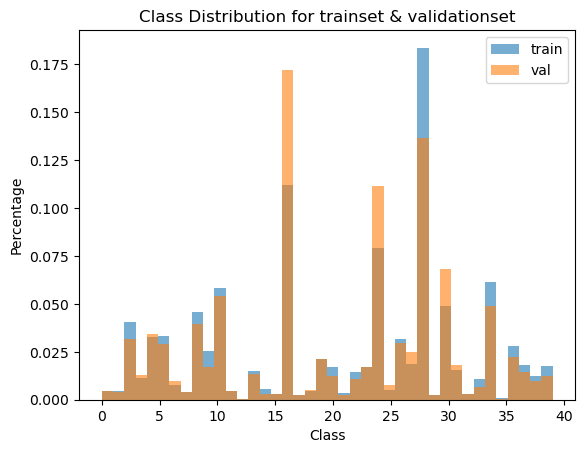

In [8]:
import matplotlib.pyplot as plt

plt.hist(data[0].y[data[0].train_mask].reshape(-1,), histtype="bar", bins=40, alpha=0.6,  label="train", density=True)
plt.hist(data[0].y[data[0].val_mask].reshape(-1,), histtype="bar", bins=40, alpha=0.6, label="val", density=True)
plt.legend()
plt.title("Class Distribution for trainset & validationset")
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.show()

In [9]:
min_value = data[0].node_year[data[0].train_mask].min()
max_value = data[0].node_year[data[0].train_mask].max()
diff = max_value - min_value

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = GAT(hidden_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    optimizer.zero_grad()
    out = model(
        torch.concatenate((data[0].x, (data[0].node_year - min_value) / diff), axis=1).to(device), 
        data[0].edge_index.to(device)
    )
    loss = criterion(
        out[data[0].train_mask].to(device),
        data[0].y[data[0].train_mask].reshape(-1,).to(device)
    )
    loss.backward()
    optimizer.step()
    return loss


def test():
    model.eval()
    out = model(
        torch.concatenate((data[0].x, (data[0].node_year - min_value) / diff), axis=1).to(device), 
        data[0].edge_index.to(device)
    )
    pred = out.argmax(dim=1).detach().cpu()
    test_correct = pred[data[0]
                        .val_mask] == data[0].y[data[0].val_mask].reshape(-1,)
    test_acc = int(test_correct.sum()) / len(test_correct)
    return test_acc, pred[data[0].val_mask], data[0].y[data[0].val_mask].reshape(-1,)


for epoch in range(1, 601):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    test_acc, test_pred, test_true = test()
    print(f'Test Accuracy: {test_acc:.4f}')

cuda


Epoch: 001, Loss: 5.4624
Test Accuracy: 0.1331
Epoch: 002, Loss: 4.6348
Test Accuracy: 0.1331
Epoch: 003, Loss: 3.6287
Test Accuracy: 0.2220
Epoch: 004, Loss: 3.3498
Test Accuracy: 0.1239
Epoch: 005, Loss: 3.1365
Test Accuracy: 0.1494
Epoch: 006, Loss: 3.1303
Test Accuracy: 0.1475
Epoch: 007, Loss: 3.1031
Test Accuracy: 0.1396
Epoch: 008, Loss: 3.0416
Test Accuracy: 0.1963
Epoch: 009, Loss: 2.8765
Test Accuracy: 0.2873
Epoch: 010, Loss: 2.7662
Test Accuracy: 0.2747
Epoch: 011, Loss: 2.7442
Test Accuracy: 0.2911
Epoch: 012, Loss: 2.6766
Test Accuracy: 0.2859
Epoch: 013, Loss: 2.6396
Test Accuracy: 0.3239
Epoch: 014, Loss: 2.5459
Test Accuracy: 0.3834
Epoch: 015, Loss: 2.4978
Test Accuracy: 0.3995
Epoch: 016, Loss: 2.4544
Test Accuracy: 0.3969
Epoch: 017, Loss: 2.3780
Test Accuracy: 0.3803
Epoch: 018, Loss: 2.3381
Test Accuracy: 0.3812
Epoch: 019, Loss: 2.2924
Test Accuracy: 0.3919
Epoch: 020, Loss: 2.2635
Test Accuracy: 0.4086
Epoch: 021, Loss: 2.2121
Test Accuracy: 0.4188
Epoch: 022, L

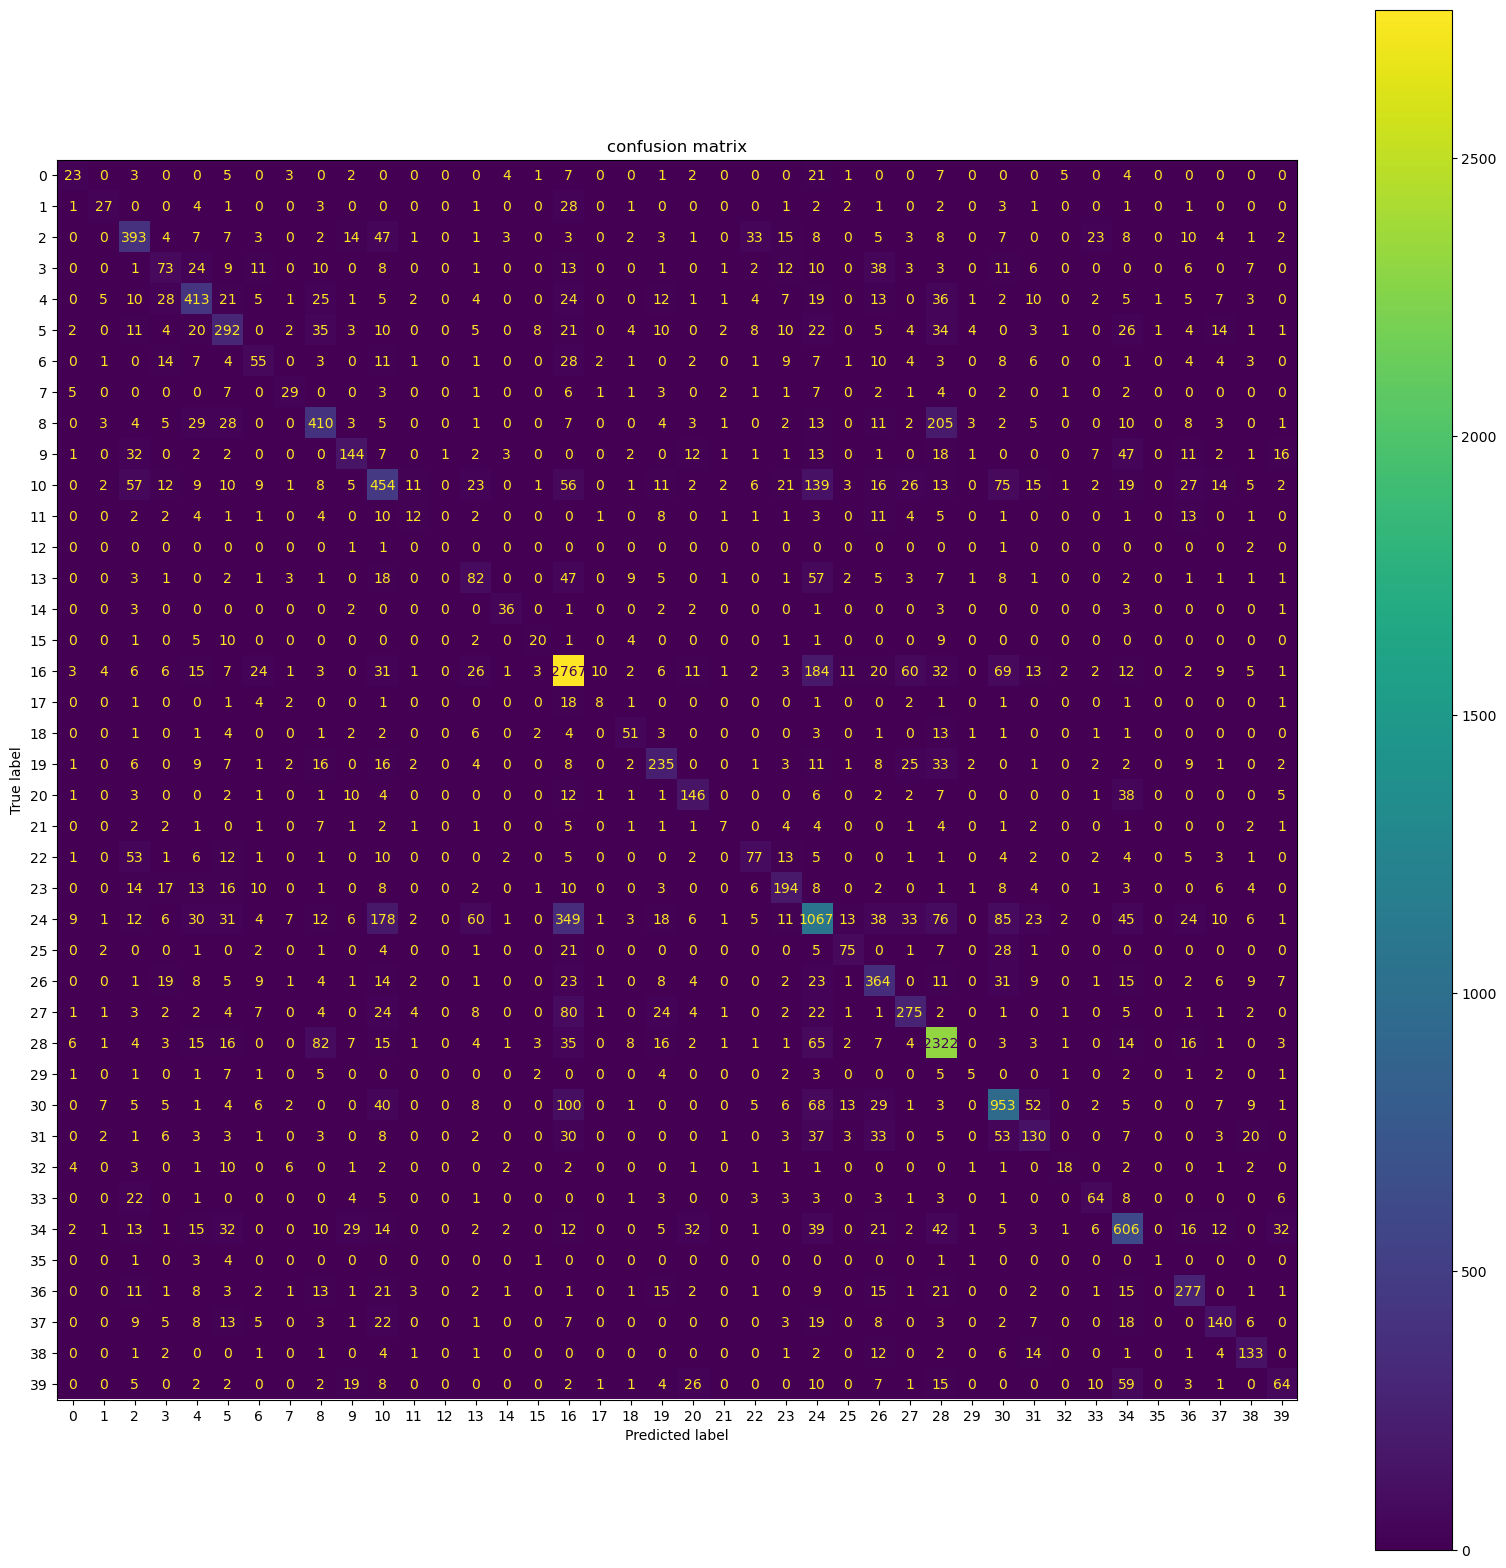

In [15]:
plt.rcParams['figure.figsize'] = [20, 20]
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_true, test_pred, labels=list(range(0, 40)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0, 40)))
disp.plot()
plt.title("confusion matrix")
plt.show()
